In [1]:
 !pip install --upgrade plotly

     |████████████████████████████████| 25.3 MB 1.2 MB/s 
  Attempting uninstall: plotly
    Found existing installation: plotly 4.4.1
    Uninstalling plotly-4.4.1:
      Successfully uninstalled plotly-4.4.1


In [2]:
!pip install dill

In [3]:
import dill
import numpy as np
import pandas as pd
import time
import math
import copy
import random
from matplotlib import pyplot as plt
import seaborn as sns
import pprint
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from numpy.linalg import norm
import plotly.express as px

In [22]:
# Since computing this entire notebook can take several hours, we serialized 
# variables so if the marker wanted to run the notebook from scratch they can do
# so without having to run the long compare functions.
# Note: compare functions can still be run of course, they will just take time
# and replace the serialized variables with new values.
dill.load_session("./activations.db")
dill.load_session("./F21BC.db")
dill.load_session("./comparators.db")
dill.load_session("./optimals.db")

In [5]:
data = pd.read_csv("./data_banknote_authentication.txt", header=None)
m, n = data.shape
# seperate into input and output features
X, Y = data.values[:, :-1], data.values[:, -1]
Y = LabelEncoder().fit_transform(Y)
# split into train and test datasets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3)

X_train = X_train.T
X_test = X_test.T

In [6]:
def relu(Z):
    return np.maximum(Z, 0)

def tanh(Z):
    return np.tanh(Z)

def sigmoid(Z):
    # prevent exp overflow arning does not affect calculation as it becomes 0
    np.warnings.filterwarnings('ignore', 'overflow')
    return 1/(1+np.exp(-Z))

def softmax(Z):
    A = np.exp(Z) / sum(np.exp(Z))
    return A

def relu_deriv(Z):
    return Z > 0

def tanh_deriv(Z):
    return 1-np.tanh(Z)**2

def sigmoid_deriv(Z):
    sig = 1/(1+np.exp(-Z))
    return sig * (1 - sig)

def one_hot(Y):
    one_hot_Y = np.zeros((Y.size, Y.max() + 1))
    one_hot_Y[np.arange(Y.size), Y] = 1
    one_hot_Y = one_hot_Y.T
    return one_hot_Y

In [7]:
class NeuralNetwork:
    def __init__(self, layer_sizes, activations):
            self.layer_sizes = layer_sizes
            self.activations = activations
            self.params = {}
            self.last = len(self.layer_sizes)
            self.init_params()
            self.accuracy = None
            self.X = None
            self.Y = None
            
    def __repr__(self):
        return f"ANN Hyperparameters\nLayers: {self.layer_sizes}\nActivations: {self.activations}"
    
    # Initalize the network with random weights and biases
    def init_params(self):
        # Initalize the network with random weights and biases 
        params = self.params
        for i in range(1, self.last):
            params[f'W{i}'] = np.random.rand(self.layer_sizes[i], self.layer_sizes[i-1]) - 0.5
            params[f'B{i}'] = np.random.rand(self.layer_sizes[i],1) - 0.5

    def forward_propagation(self, X):
        # Pass X through the network 
        params = self.params
        for i in range(1, self.last):
            if i==1:
                # For first layer compute dot with x
                output = params[f'W{i}'].dot(X) + params[f'B{i}']
            else: 
                # For all other layers compute with output of prev layer
                output = params[f'W{i}'].dot(params[f'A{i-1}']) + params[f'B{i}']
          
            # For all other layers use the activ_fnc initalized in constructor
            activ_fnc = self.activations[i-1]
            activations = globals()[activ_fnc](output)
            
            params[f'Z{i}'] = output
            params[f'A{i}'] = activations


    def unroll_params(self):
        params = self.params
        unrolled_params = []
        for i in range(1, self.last):
            unrolled_params.extend(params[f'W{i}'].flatten())
            unrolled_params.extend(params[f'B{i}'].flatten())
            
        return np.array(unrolled_params)        
    

    def calc_loss(self, Y):
        ohY = one_hot(Y)
        params = self.params
        losses = params[f'A{self.last-1}'] - ohY
        return np.abs(losses).mean()

        
    # Not needed
    def backward_propagation(self, X, Y):
        ohY = one_hot(Y)
        params = self.params
        
        for i in range(self.last - 1, 0, -1):
            if(i == self.last - 1):
                # For final layer calculate how wrong net is and compute gradients for weights and biases
                dZ =  params[f'A{i}'] - ohY
                params[f'dZ{i}'] = dZ
                params[f'dW{i}'] = 1 / m * dZ.dot(params[f'A{i-1}'].T)
                params[f'dB{i}'] = 1 / m * np.sum(dZ)
            elif (i == 1):
                # For first layer compute the gradients for weights and biases with input of dataset
                dZ = params[f'W{i+1}'].T.dot(params[f'dZ{i+1}']) * globals()[f'{self.activations[i-1]}_deriv'](params[f'Z{i}'])
                params[f'dZ{i}'] = dZ
                params[f'dW{i}'] = 1 / m * dZ.dot(X.T)
                params[f'dB{i}'] = 1 / m * np.sum(dZ)
            else: 
                # For all other layers compute the gradients for weights and biases with the output of the prev layer
                dZ = params[f'W{i+1}'].T.dot(params[f'dZ{i+1}']) * globals()[f'{self.activations[i-1]}_deriv'](params[f'Z{i}'])
                params[f'dZ{i}'] = dZ
                params[f'dW{i}'] = 1 / m * dZ.dot(params[f'A{i-1}'].T)
                params[f'dB{i}'] = 1 / m * np.sum(dZ)

    def train(self, X, Y, printAccuracy=False):
        self.X = X
        self.Y = Y
        for i in range(50):
            self.forward_propagation(X)
            self.backward_propagation(X, Y)
            self.update_params(0.1)

            predictions = self.get_preds()
            self.accuracy = self.get_accuracy(predictions, Y)
            # Print accuracy every 10 iterations
            if(printAccuracy==True):
                if i % 1 == 0:
                    print("Iteration: ", i)
                    print('Accuracy: ', self.accuracy)
      
        return self.params
            
    def update_params(self, new_params):
        params = self.params
        layer_sizes = self.layer_sizes
        start_index = 0
        for i in range(1, self.last):
            wx, wy = params[f'W{i}'].shape
            bx, _ = params[f'B{i}'].shape

            end_weights = start_index + wx * wy
            end_biases = end_weights + bx
            
            params[f'W{i}'] = new_params[start_index:end_weights].reshape(wx, wy)
            params[f'B{i}'] = new_params[end_weights:end_biases].reshape(bx, 1)
            
            start_index = end_biases

    def make_preds(self, X):
        self.forward_propagation(X)
        predictions = self.get_preds()
        return predictions

    def test_preds(self, i):
        curr = X_train[:, i, None]
        print("label ", Y_train[i])
        print("predicted ", self.make_preds(curr)[0])

    def get_preds(self):
        return np.argmax(self.params[f'A{self.last-1}'], 0)

    def get_accuracy(self, predictions, Y):
        return np.sum(predictions == Y) / Y.size
    
    def set_activations(self, acts):
      self.activations = acts
    

In [8]:
class Particle:
    counter = 1
    def __init__(self,x0, num_dem, constants=[0.5, 0.3]):
        self.position_i=[]          # particle position
        self.velocity_i=[]          # particle velocity
        self.pos_best_i=[]          # best position individual
        self.err_best_i=-1          # best error individual
        self.err_i=-1               # error individual
        self.num_dimensions = num_dem
        self.informants = []
        self.name = "Particle: " + str(Particle.counter)
        self.constants = constants
        self.activation = None
        Particle.counter +=1 

        for i in range(0,self.num_dimensions):
            self.velocity_i.append(random.uniform(-1,1))
            self.position_i.append(x0[i])

    # evaluate current fitness
    def evaluate(self,cost):
        self.err_i=cost

        # check to see if the current position is an individual best
        if self.err_i < self.err_best_i or self.err_best_i==-1:
            self.pos_best_i=self.position_i
            self.err_best_i=self.err_i

    # update new particle velocity
    def update_velocity(self,pos_best_g):
        w=0.9       # constant inertia weight (how much to weigh the previous velocity)
        c1=self.constants[0]        # cognative constant
        c2=self.constants[1]        # social constant

        for i in range(0,self.num_dimensions):
            r1=random.random()
            r2=random.random()

            try:
                vel_cognitive=c1*r1*(self.pos_best_i[i]-self.position_i[i])
                vel_social=c2*r2*(pos_best_g[i]-self.position_i[i])
                self.velocity_i[i]=w*self.velocity_i[i]+vel_cognitive+vel_social
            except IndexError as error:
                print(error)
                print(i)
                print(len(pos_best_g))
                print(len(self.position_i))
            
    # update the particle position based off new velocity updates
    def update_position(self):
        for i in range(0,self.num_dimensions):
            self.position_i[i]=self.position_i[i]+self.velocity_i[i]

    def evaluate_informants(self):
        lowest_cost = math.inf
        best_informant = None
        for particle in self.informants:
            if particle.err_i < lowest_cost:
                lowest_cost = particle.err_i
                best_informant = particle
                
        return lowest_cost, best_informant.position_i

In [9]:
class PSO:
    def __init__(self, costFunc, num_dem, num_particles, maxiter, num_informants,
                 method, max_dist, activations, defaultActs, constants=[0.5, 0.3],
                 randomActivations=False):
        self.num_dimensions = num_dem
        self.num_particles = num_particles
        self.err_best_g = -1  # best error for group
        self.pos_best_g = []  # best position for group
        self.maxiter = maxiter
        self.swarm = []
        self.costFunc = costFunc
        self.defaultActs = defaultActs
        self.random_activations = randomActivations
        self.passed_activations = activations
        self.best_activations = None
        
        # establish the swarm
        self.create_swarm(constants)
        
        # create informants
        self.create_informants(num_informants, method, max_dist)
        
        # begin optimization loop
        self.optimize_swarm()
        

    def create_swarm(self, constants):
        for i in range(0, self.num_particles):
            x0 = np.random.rand(self.num_dimensions) - 0.5
            self.swarm.append(Particle(x0, self.num_dimensions, constants))


    def optimize_swarm(self):
        i = 0
        while i < self.maxiter:
            # print(np.array([s.position_i for s in swarm])[0])

            # print i,err_best_g
            # cycle through particles in swarm and evaluate fitness
            costs = self.costFunc(np.array([s.position_i for s in self.swarm]))
            
            for x in range(0, self.num_particles):
                self.swarm[x].evaluate(costs[x])
                if self.random_activations == True:
                  particle_activation = self.passed_activations[x]
                else:
                  particle_activation = self.defaultActs
                self.swarm[x].activation = particle_activation

            for j in range(0, self.num_particles):
                # if particle has no informants, which is possible in case of distance method,
                # then use global best values from the swarm, i.e. every particle is an informant
                if len(self.swarm[j].informants) == 0:
                    # determine if current particle is the best (globally)
                    if self.swarm[j].err_i < self.err_best_g or self.err_best_g == -1:
                        self.pos_best_g = list(self.swarm[j].position_i)
                        self.err_best_g = float(self.swarm[j].err_i)
                        self.best_activations = self.swarm[j].activation
                else:
                    best_informant_cost, best_informant_position = self.swarm[j].evaluate_informants()
                    
                    if self.swarm[j].err_i < best_informant_cost:
                        
                        # We continue to use pos and err with the suffix "best_g", but it is best values
                        # among the informants and not globally. But because they serve the same purpose,
                        # i.e. informants being the particle's "globe", the global suffix helps keep code
                        # streamlined.

                        self.pos_best_g = list(best_informant_position)
                        self.err_best_g = float(best_informant_cost)
                        self.best_activations = self.swarm[j].activation
                  
            # cycle through swarm and update velocities and position
            for j in range(0, self.num_particles):
                self.swarm[j].update_velocity(self.pos_best_g)
                self.swarm[j].update_position()
            i += 1

    def get_train(self):
        return self.err_best_g, self.pos_best_g
    
    def get_best_activations(self):
      return self.best_activations

    def create_informants(self, num_informats, method="distance", max_distance=10):
        # If distance method is choosen, there is no guarantee minimum num_informants will be created.
        # because no other particle may be present within the max distance specified.
        
        for particle in self.swarm:
            
            if method == "distance":
                for i in range(self.num_particles):
                    if particle.name != self.swarm[i].name:
                        particle_position = np.asarray(particle.position_i)
                        potential_informant_position = np.asarray(self.swarm[i].position_i)
                        difference = abs( particle_position - potential_informant_position )
                        within_distance = difference < max_distance
                        distance_met = np.count_nonzero(within_distance)
                        
                        if distance_met == len(particle.position_i):
                            particle.informants.append(self.swarm[i])
                        
                    
#                     print(len(particle.informants))
                    if len(particle.informants) == num_informats:
                        break

                
            if method == "random":
                indexes = random.sample(range(self.num_particles), num_informats)
                for i in indexes:
                    if particle.name != self.swarm[i].name:
                        particle.informants.append(self.swarm[i])
                    else:
                        new_index = i
                        while(particle.name != self.swarm[new_index].name):
                            new_index = random.randint(0, self.num_particles)
                        particle.informants.append(self.swarm[new_index])


In [ ]:
nn = NeuralNetwork([4,10,10,10,2], ['relu','relu','relu','sigmoid'])

In [10]:
def train_swarm(network, X, Y, n_particles, iterations, num_informants, method,
                max_dist, constants=[0.5, 0.3], randomActivations=False):
    layer_sizes = network.layer_sizes
    dimensions = sum([layer_sizes[i-1] * layer_sizes[i] + layer_sizes[i] for i in range(1,len(layer_sizes))])
    nets = [copy.deepcopy(network) for i in range(n_particles)]
    init_activations = network.activations
    available_activations = ["relu", "tanh", "sigmoid"]
    passed_activations = []
    logs = {"acc_epoch_list": [], "acc_time_list": [], "best_acc": 0.0}
    start = time.perf_counter()
    
    def calc_single_cost(i, params):
        if randomActivations == True:
          num_activations = len(nets[i].layer_sizes) - 1
          random_activations = random.choices(available_activations, k=num_activations)
          passed_activations.append(random_activations)
          nets[i].set_activations(random_activations)
        
        nets[i].update_params(params)
        nets[i].forward_propagation(X)
        return nets[i].calc_loss(Y)

    def calc_all_costs(x):
        j = np.array([calc_single_cost(i,x[i]) for i in range(n_particles)])
        b_net = nets[np.argmin(j)]
        b_acc = b_net.get_accuracy(b_net.get_preds(), Y)
        logs["best_acc"] = b_acc
        logs["acc_epoch_list"].append((len(logs["acc_epoch_list"]), b_acc))
        logs["acc_time_list"].append(((time.perf_counter() - start), b_acc))
        return j

    pso = PSO(calc_all_costs, dimensions, n_particles, iterations, num_informants,
              method, max_dist, passed_activations, init_activations,
              constants=[0.5, 0.3], randomActivations=False)
    err, pos = pso.get_train()
    best_activations = pso.get_best_activations()
    stop = time.perf_counter()
    
    best_net = copy.deepcopy(network)
    best_net.set_activations(best_activations)
    best_net.update_params(np.array(pos))

    return best_net, logs

## Informal Investigation
Informally test different values of hyperparameters

##### Train vs Test

In [ ]:
trained_net, net_logs = train_swarm(NeuralNetwork([4,10,10,10,2], ['relu','relu','relu','sigmoid']), X_train, Y_train, 100, 200, 5, "distance", 0.85)

In [ ]:
trained_net.forward_propagation(X_train)
predictions = trained_net.get_preds()
accuracy = trained_net.get_accuracy(predictions, Y_train)

In [ ]:
accuracy # accuracy for single run using optimal ANN hyperparameters on training data

1.0

In [ ]:
trained_net.forward_propagation(X_test)
predictions_test = trained_net.get_preds()
accuracy_test = trained_net.get_accuracy(predictions_test, Y_test)

In [ ]:
accuracy_test # # accuracy for single run using optimal ANN hyperparameters on testing data

0.9951456310679612

* There is limited overfitting as model fits well to new data

##### Iterations

In [ ]:
# 100 iterations on test data
trained_net_itr1, net_logs_itr1 = train_swarm(NeuralNetwork([4,10,10,10,2], ['relu','relu','relu','sigmoid']), X_train, Y_train, 100, 100, 5, "distance", 0.85)

In [ ]:
trained_net_itr1.forward_propagation(X_test)
predictions_iter1 = trained_net_itr1.get_preds()
accuracy_iter1 = trained_net_itr1.get_accuracy(predictions_iter1, Y_test)
accuracy_iter1

0.9733009708737864

In [ ]:
# 300 iterations on test data
trained_net_itr2, net_logs_itr2 = train_swarm(NeuralNetwork([4,10,10,10,2], ['relu','relu','relu','sigmoid']), X_train, Y_train, 100, 300, 5, "distance", 0.85)

In [ ]:
trained_net_itr2.forward_propagation(X_test)
predictions_iter2 = trained_net_itr2.get_preds()
accuracy_iter2 = trained_net_itr2.get_accuracy(predictions_iter2, Y_test)
accuracy_iter2

0.9781553398058253

##### Particles

In [ ]:
# 20 particles on test data
trained_net_p1, net_logs_p1 = train_swarm(NeuralNetwork([4,10,10,10,2], ['relu','relu','relu','sigmoid']), X_train, Y_train, 20, 200, 5, "distance", 0.85)

In [ ]:
trained_net_p1.forward_propagation(X_test)
predictions_p1 = trained_net_p1.get_preds()
accuracy_p1 = trained_net_p1.get_accuracy(predictions_p1, Y_test)
accuracy_p1

0.9878640776699029

In [ ]:
# 50 particles on test data
trained_net_p2, net_logs_p2 = train_swarm(NeuralNetwork([4,10,10,10,2], ['relu','relu','relu','sigmoid']), X_train, Y_train, 50, 200, 5, "distance", 0.85)

In [ ]:
trained_net_p2.forward_propagation(X_test)
predictions_p2 = trained_net_p2.get_preds()
accuracy_p2 = trained_net_p2.get_accuracy(predictions_p2, Y_test)
accuracy_p2

0.5752427184466019

##### Number of Informants

In [ ]:
# 2 informants on test data
trained_net_i1, net_logs_i1 = train_swarm(NeuralNetwork([4,10,10,10,2], ['relu','relu','relu','sigmoid']), X_train, Y_train, 100, 200, 2, "distance", 0.85)

In [ ]:
trained_net_i1.forward_propagation(X_test)
predictions_i1 = trained_net_i1.get_preds()
accuracy_i1 = trained_net_i1.get_accuracy(predictions_i1, Y_test)
accuracy_i1

0.9902912621359223

In [ ]:
# 15 informants on test data
trained_net_i2, net_logs_i2 = train_swarm(NeuralNetwork([4,10,10,10,2], ['relu','relu','relu','sigmoid']), X_train, Y_train, 100, 200, 15, "distance", 0.85)

In [ ]:
trained_net_i2.forward_propagation(X_test)
predictions_i2 = trained_net_i2.get_preds()
accuracy_i2 = trained_net_i2.get_accuracy(predictions_i2, Y_test)
accuracy_i2

0.9830097087378641

##### Method of Informants

In [ ]:
# random assignment of informants 
trained_net_m1, net_logs_m1 = train_swarm(NeuralNetwork([4,10,10,10,2], ['relu','relu','relu','sigmoid']), X_train, Y_train, 100, 200, 5, "random", 0.85)

In [ ]:
trained_net_m1.forward_propagation(X_test)
predictions_m1 = trained_net_m1.get_preds()
accuracy_m1 = trained_net_m1.get_accuracy(predictions_m1, Y_test)
accuracy_m1 # accuracy of informants being chose randomly

0.8980582524271845

* Using distance to choose the informants appears to be a more effective method than randomly choosing them

##### Maximum Distance for Informants

In [ ]:
# informant distance is 0.8
trained_net_d1, net_logs_d1 = train_swarm(NeuralNetwork([4,10,10,10,2], ['relu','relu','relu','sigmoid']), X_train, Y_train, 100, 200, 5, "distance", 0.8)

In [ ]:
trained_net_d1.forward_propagation(X_test)
predictions_d1 = trained_net_d1.get_preds()
accuracy_d1 = trained_net_d1.get_accuracy(predictions_d1, Y_test)
accuracy_d1 

1.0

In [ ]:
# informant distance is 1
trained_net_d2, net_logs_d2 = train_swarm(NeuralNetwork([4,10,10,10,2], ['relu','relu','relu','sigmoid']), X_train, Y_train, 100, 200, 5, "distance", 1)

In [ ]:
trained_net_d2.forward_propagation(X_test)
predictions_d2 = trained_net_d2.get_preds()
accuracy_d2 = trained_net_d2.get_accuracy(predictions_d2, Y_test)
accuracy_d2

0.9563106796116505

##### PSO Methods

Choosing a low distance causes the model to use global best of informants as no particles will be added as informats to other particles

In [ ]:
trained_net_g, net_logs_g = train_swarm(NeuralNetwork([4,10,10,10,2], ['relu','relu','relu','sigmoid']), X_train, Y_train, 100, 200, 5, "distance", 0.1)

In [ ]:
trained_net_g.forward_propagation(X_test)
predictions_g = trained_net_g.get_preds()
accuracy_g = trained_net_g.get_accuracy(predictions_g, Y_test)
accuracy_g

1.0

* Global appears to be better than our constructed method of informants as it reached 100% accuracy

## Formal Investigation
Random values are picked from a range and accuracy averaged over 10 runs

In [11]:
# trains network 10 times 
def run_ten(nn, X, Y, n_particles, iterations, num_informants, method,
            max_dist, constants=[0.5, 0.3], randomActivations=False, w=0.9):
    # stores run results in array
    nets = []
    for i in range(10):
        trained_net, logs = train_swarm(nn, X, Y, n_particles, iterations, num_informants, method, max_dist, randomActivations)
        nets.append([trained_net, logs])
    return np.array(nets)

In [12]:
# returns mean epoch and time at which network converged at
def get_converg(nets):
    logs = nets[:,1]
    convergFilter = np.array(list(map((lambda n: n['best_acc'] == np.float64(1)), logs)))

    convergs = list(map((lambda n: np.where(n['acc_epoch_list']==np.float64(1))[0][1]), logs[convergFilter]))
    times = list(map((lambda n: np.where(n['acc_time_list']==np.float64(1))[0][1]), logs[convergFilter]))

    mean_converg = np.mean(convergs)
    std_converg = np.std(convergs)
    mean_times = np.mean(times)
    std_times = np.std(times)
    num_non_conv = len(logs) - len(convergFilter[convergFilter]) # number of networks that did not converge to 100%
    
    return mean_converg, std_converg, mean_times, std_times, num_non_conv

In [13]:
# gets mean and standard deviation for accuracy 
def get_metrics(nets):
    logs = nets[:,1]
    
    accuracies = np.array(list(map((lambda n: n['best_acc']), logs)))

    mean = np.mean(accuracies)
    std = np.std(accuracies)
    return mean, std

In [ ]:
# optimal hyperparameters from informal investigation over 10 runs
ten_nets = run_ten(NeuralNetwork([4,10,10,10,2], ['relu','relu','relu','sigmoid']), X_train, Y_train, 20, 300, 5, "distance", 0.8)

In [ ]:
get_metrics(ten_nets)

(0.9926041666666665, 0.011862658060063928)

* optimal ANN and PSO hyperparameters from informal investigation appears to get high accuracy at 99.3% with very low standard deviation, meaning all the accuracy values are very similar

In [14]:
def view_accuracyEpoch(acc_epoch_list):
    sns.set(rc={'figure.figsize':(15,8)})
    df = pd.DataFrame(acc_epoch_list, columns=["Epochs", "Accuracy"])
    sns.lineplot(data=df, x="Epochs", y="Accuracy", ci=None)
    

In [15]:
def view_accuracyEpochAll(nets):
    logs = nets[:,1]

    ordered_logs = sorted(logs, key=lambda item: item['best_acc'], reverse=True)


    acc_epoch_lists = np.array([n['acc_epoch_list'] for n in ordered_logs])
    acc_time_lists = np.array([n['acc_time_list'] for n in ordered_logs])

    temp = acc_epoch_lists[:,:,1]
    
    df = pd.DataFrame(temp).T
    df.columns = [ chr(i+65) for i in range(len(df.columns)) ]
    df.reset_index(drop=True, inplace=True)

    print(df.shape)
    fig = px.line(df, title='Accuracy Vs Epochs')
    fig.update_xaxes(title_text='Epochs')
    fig.update_yaxes(title_text='Accuracy')
    fig.update_layout(legend_title_text='Runs (Asc)')
    
    fig.show()

In [ ]:
# accuracy over epochs for optimal PSO hyperparameters from informal investigation
tesa = view_accuracyEpochAll(ten_nets)

(300, 10)


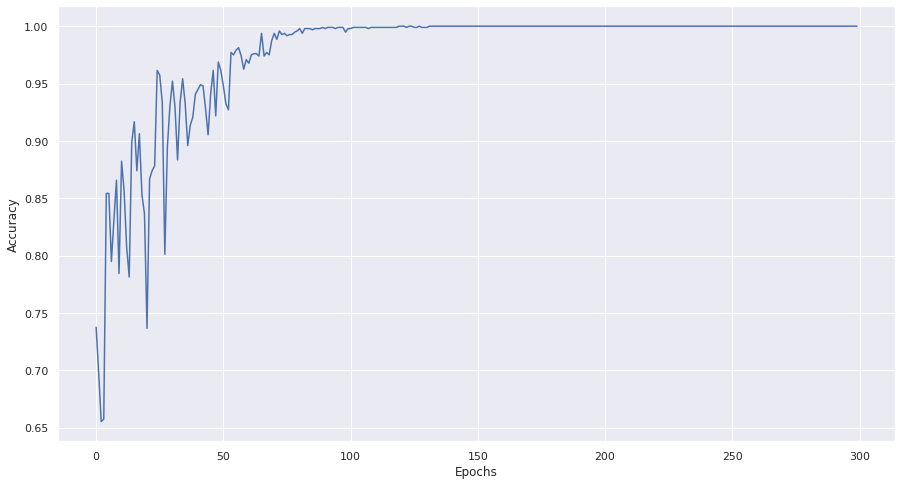

In [ ]:
# Closer view of Run A
view_accuracyEpoch(ten_nets[0][1]['acc_epoch_list'])

In [ ]:
# compares a specifed sample number for randomly selected number of hidden layers within a defined range
def compareLayers(nn, X, Y, lower, upper):
    test_values = range(lower, upper) 
    results = {}
    
    for nl in test_values: 
        activations = list(map(lambda x: 'relu', range(nl)))
        activations.append('sigmoid')
        
        layers = list(map(lambda x: 10, range(nl)))
        layers.append(nn.layer_sizes[len(nn.layer_sizes) - 1])
        layers.insert(0, nn.layer_sizes[0])

        new_net = NeuralNetwork(layers, activations)
        ten_nets = run_ten(new_net, X_train, Y_train, 300, 100, 25, "distance", 0.75)
        
        results[nl] = [get_metrics(ten_nets), ten_nets]
        
        
        print('progress', f'{nl}/{len(test_values)}')
    # results are sorted descending based on mean accuracy   
    sorted_by_mean = dict(sorted(results.items(), key=lambda item: item[1][0]))
    for key, value in sorted_by_mean.items():
        print('ly', key, ' : ', 'mean accuracy',round(value[0][0], 4), f' std dev ({round(value[0][1], 4)})')        

    return sorted_by_mean

##### Compare Activation Functions

In [ ]:
def compareActivations(nn, X, Y, ntests):
  best_activations_observed = []

  print("Progress:")
  # training using random activations
  for i in range(ntests):
    # run ten times, choose the best activation. Repeat ntests times. Choose best from them.

    ## REDUCING PARAMS HERE FOR TESTING PURPOSES. 300->10, 100->10
    ## Reduce those two params if you want to test this function quickly
    ten_nets = run_ten(nn, X_train, Y_train, 300, 100, 25, "distance", 0.75, randomActivations=True)
    # store best activation from each run
    acts = [ten_nets[i][0].activations for i in range(len(ten_nets))]

    # unsorted dic with best activation observed in each run with their total count
    act_dictionary = {}
    for element in acts:
      act_dictionary[tuple(element)] = acts.count(element)
    
    #same dic but sorted by count
    sorted_acts = sorted(act_dictionary.items(), key=lambda item: item[1], reverse=True)
    
    # most recurring best activation.
    # If no combination of activations occurs more than once, the first one is chosen.
    
    best_act = sorted_acts[0][0]
    best_activations_observed.append(best_act)
    print(f"{i+1}/{ntests}")
  
  best_acts = {}
  for element in best_activations_observed:
    best_acts[element] = best_activations_observed.count(element)
  
  #same dic but sorted by count
  sorted_best_acts = sorted(best_acts.items(), key=lambda item: item[1], reverse=True)
  #print(sorted_best_acts)
  # most recurring best activation 
  
  best_act = list(sorted_best_acts[0][0])
  print(f"Best activation function found: {best_act}.")
  
  return best_act



In [ ]:
best_act = compareActivations(NeuralNetwork([4,10,10,10,2], ['relu','relu','relu','sigmoid']), X_train, Y_train, 10)

In [ ]:
# This value of best activations come from a previous run which were serialized.
best_act

['relu', 'relu', 'sigmoid', 'tanh']

In [ ]:
#dill.dump_session("./activations.db")

##### Compare Number of Particles

In [ ]:
# compares a specifed sample number for randomly selected number of particles within a defined range
def compareParticles(nn, X, Y, lower, upper, n_tests):
    test_values = list(map(lambda x: random.randint(lower, upper), range(n_tests))) 
    results = {}

    i = 1
    for pt in test_values: 
        ten_nets = run_ten(nn, X_train, Y_train, pt, 300, 5, "distance", 0.8)
        results[pt] = [get_metrics(ten_nets), ten_nets]
        print('progress', f'{i}/{len(test_values)}')
        i+=1
            
    # results are sorted descending based on mean accuracy   
    sorted_by_mean = dict(sorted(results.items(), key=lambda item: item[1][0]))
    for key, value in sorted_by_mean.items():
        print('pt', key, ' : ', 'mean accuracy',round(value[0][0], 4), f' std dev ({round(value[0][1], 4)})')        

    return sorted_by_mean

In [ ]:
comparedParticles = compareParticles(NeuralNetwork([4,10,10,10,2], ['relu','relu','relu','sigmoid']), X_train, Y_train, 10, 100, 10)

progress 1/10
progress 2/10
progress 3/10
progress 4/10
progress 5/10
progress 6/10
progress 7/10
progress 8/10
progress 9/10
progress 10/10
pt 13  :  mean accuracy 0.9752  std dev (0.0463)
pt 29  :  mean accuracy 0.9968  std dev (0.0045)
pt 41  :  mean accuracy 0.9975  std dev (0.0021)
pt 97  :  mean accuracy 0.9991  std dev (0.0022)
pt 78  :  mean accuracy 0.9994  std dev (0.0013)
pt 71  :  mean accuracy 0.9998  std dev (0.0004)
pt 74  :  mean accuracy 0.9998  std dev (0.0006)
pt 77  :  mean accuracy 0.9999  std dev (0.0003)
pt 64  :  mean accuracy 1.0  std dev (0.0)


In [ ]:
# 10 runs from the highest accuracy found from number of particles search
key1_p = list(comparedParticles.keys())[9]
view_accuracyEpochAll(comparedParticles[key1_p][1])

(300, 10)


##### Compare Number of Informants

In [ ]:
# compares a specifed sample number for randomly selected number of informants within a defined range
def compareNumInform(nn, X, Y, lower, upper, n_tests):
    test_values = list(map(lambda x: random.randint(lower, upper), range(n_tests))) 
    results = {}

    i = 1
    for ni in test_values: 
        ten_nets = run_ten(nn, X_train, Y_train, 20, 300, ni, "distance", 0.8)
        results[ni] = [get_metrics(ten_nets), ten_nets]
        print('progress', f'{i}/{len(test_values)}')
        i+=1
            
    # results are sorted descending based on mean accuracy   
    sorted_by_mean = dict(sorted(results.items(), key=lambda item: item[1][0]))
    for key, value in sorted_by_mean.items():
        print('ni', key, ' : ', 'mean accuracy',round(value[0][0], 4), f' std dev ({round(value[0][1], 4)})')        

    return sorted_by_mean

In [ ]:
compardInformants = compareNumInform(NeuralNetwork([4,10,10,2], ['relu','relu','sigmoid']), X_train, Y_train, 2, 10, 10)


progress 1/10
progress 2/10
progress 3/10
progress 4/10
progress 5/10
progress 6/10
progress 7/10
progress 8/10
progress 9/10
progress 10/10
ni 8  :  mean accuracy 0.9206  std dev (0.1567)
ni 2  :  mean accuracy 0.9372  std dev (0.1331)
ni 6  :  mean accuracy 0.938  std dev (0.1311)
ni 4  :  mean accuracy 0.9709  std dev (0.0761)
ni 10  :  mean accuracy 0.9772  std dev (0.0593)
ni 9  :  mean accuracy 0.9954  std dev (0.0037)
ni 3  :  mean accuracy 0.9981  std dev (0.003)


In [ ]:
# 10 runs from the highest accuracy found from number of iterations search
key1_i = list(compardInformants.keys())[6]
view_accuracyEpochAll(compardInformants[key1_i][1])

(300, 10)


##### Compare Informant Distance

In [ ]:
# compares a specifed sample number of randomly selected distance within a defined range
def compareInformDist(nn, X, Y, lower, upper, n_tests):
    test_values = list(map(lambda x: random.uniform(lower, upper), range(n_tests))) 
    results = {}

    i = 1
    for ni in test_values: 
        ten_nets = run_ten(nn, X_train, Y_train, 20, 300, 5, "distance", ni)
        results[ni] = [get_metrics(ten_nets), ten_nets]
        print('progress', f'{i}/{len(test_values)}')
        i+=1
            
    # results are sorted descending based on mean accuracy   
    sorted_by_mean = dict(sorted(results.items(), key=lambda item: item[1][0]))
    for key, value in sorted_by_mean.items():
        print('dst', key, ' : ', 'mean accuracy',round(value[0][0], 4), f' std dev ({round(value[0][1], 4)})')        

    return sorted_by_mean

In [ ]:
comparedDist = compareInformDist(NeuralNetwork([4,10,10,10,2], ['relu','relu','relu','sigmoid']), X_train, Y_train, 0.7, 1, 10)

progress 1/10
progress 2/10
progress 3/10
progress 4/10
progress 5/10
progress 6/10
progress 7/10
progress 8/10
progress 9/10
progress 10/10
dst 0.950732644784559  :  mean accuracy 0.6423  std dev (0.1182)
dst 0.8963436847943732  :  mean accuracy 0.6495  std dev (0.1518)
dst 0.9522240991960592  :  mean accuracy 0.6972  std dev (0.1272)
dst 0.9534424535731494  :  mean accuracy 0.7133  std dev (0.1507)
dst 0.8773788483585386  :  mean accuracy 0.7821  std dev (0.177)
dst 0.8126997010773538  :  mean accuracy 0.9289  std dev (0.1302)
dst 0.722208437724138  :  mean accuracy 0.9548  std dev (0.1297)
dst 0.7195411084536663  :  mean accuracy 0.9866  std dev (0.0297)
dst 0.7851463279895465  :  mean accuracy 0.9889  std dev (0.0283)
dst 0.7087270882046018  :  mean accuracy 0.994  std dev (0.0071)


In [ ]:
# 10 runs from the highest accuracy found from distance search
key1_d = list(comparedDist.keys())[9]
view_accuracyEpochAll(comparedDist[key1_d][1])

(300, 10)


##### Compare Acceleration Constants

In [ ]:
def compareConstants(nn, X, Y, lower, upper):
  
   results = {}
   nets = {}
   print("Progress:")

   # Case One: c1 = c2
   caseOne = run_ten(nn, X_train, Y_train, 300, 100, 25, "distance",
                           0.95, constants=[0.5, 0.5])
   nets["c1  = c2"] = caseOne
   results["c1  = c2"]= [get_metrics(caseOne), caseOne]
   print("1/5")
   
   
   # Case Two: c1 > c2
   caseTwo = run_ten(nn, X_train, Y_train, 300, 100, 25, "distance",
                               0.95, constants=[upper, lower])
   nets["c1  > c2"] = caseTwo
   results["c1  > c2"]=[get_metrics(caseTwo), caseTwo]
   print("2/5")

   # Case Three: c1 < c2
   caseThree = run_ten(nn, X_train, Y_train, 300, 100, 25, "distance",
                               0.95, constants=[lower, upper])
   nets["c1  < c2"] = caseThree
   results["c1  < c2"]= [get_metrics(caseThree), caseThree]
   print("3/5")
   
   # Case Four: c1 >> c2
   caseFour = run_ten(nn, X_train, Y_train, 300, 100, 25, "distance",
                               0.95, constants=[upper*2, lower*0.01])
   nets["c1 >> c2"] = caseFour
   results["c1 >> c2"]= [get_metrics(caseFour), caseFour]
   print("4/5")
   
   # Case Five: c1 << c2
   caseFive = run_ten(nn, X_train, Y_train, 300, 100, 25, "distance",
                               0.95, constants=[lower*0.01, upper*2])
   nets["c1 << c2"] = caseFive
   results["c1 << c2"]= [get_metrics(caseFive), caseFive]
   print("5/5")
   
   # results are sorted descending based on mean accuracy
   sorted_by_mean = dict(sorted(results.items(), key=lambda item: item[1][0]))
   for key, value in sorted_by_mean.items():
     print( key, ':', 'mean accuracy', round(value[0][0], 4), f' std dev ({round(value[0][1], 4)})')
  
   return sorted_by_mean, nets

In [ ]:
def viewConstants(constantNets):
  # constantNets is a dictionary with each case as a key, and ten runs as their value.
  for key,value in constantNets.items():
    # Accessing a random run from this case and plotting it
    i = random.randint(0,9)
    sns.set(rc={'figure.figsize':(15,8)})
    df = pd.DataFrame(value[i][1]['acc_epoch_list'], columns=["Epochs", "Accuracy"])
    sns.lineplot(data=df, x="Epochs", y="Accuracy", ci=None, label=key)

    

In [ ]:
comparedConstants, constantNets = compareConstants(NeuralNetwork([4,10,10,10,2], ['relu','relu','relu','sigmoid']), X_train, Y_train, 0.1, 0.9)

Progress:
1/5
2/5
3/5
4/5
5/5
c1  = c2 : mean accuracy 0.8855  std dev (0.1584)
c1  > c2 : mean accuracy 0.946  std dev (0.1273)
c1 << c2 : mean accuracy 0.9566  std dev (0.0699)
c1 >> c2 : mean accuracy 0.9652  std dev (0.0741)
c1  < c2 : mean accuracy 0.9897  std dev (0.0177)


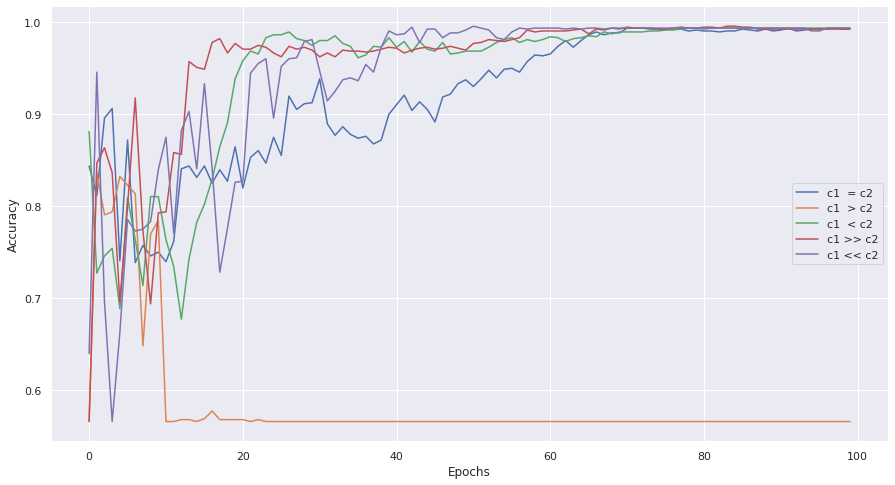

In [ ]:
viewConstants(constantNets)

In [ ]:
def compareCognitiveSocial(nn, X, Y, lower, upper, n_tests):
    test_values = [[round(random.uniform(lower, upper), 4),round(random.uniform(lower, upper), 4)] for i in range(n_tests)]
    results = {}

    i = 1
    for ia in test_values: 
        c1 = ia[0]
        c2 = ia[1]
        ten_nets = run_ten(nn, X_train, Y_train, 20, 300, 5, "distance", 0.85, constants=[c1, c2])
        index = ",".join(str(v) for v in ia)
        results[index] = [get_metrics(ten_nets), ten_nets]
        print('progress', f'{i}/{len(test_values)}')
        i+=1
            
    # results are sorted ascending based on mean accuracy   
    sorted_by_mean = dict(sorted(results.items(), key=lambda item: item[1][0]))
    for key, value in sorted_by_mean.items():
        print('dst', key, ' : ', 'mean accuracy',round(value[0][0], 4), f' std dev ({round(value[0][1], 4)})')        

    return sorted_by_mean

In [ ]:
base_net = NeuralNetwork([4,10,10,10,2], ['relu','relu','relu','sigmoid'])

In [ ]:
comparedCogSoc = compareCognitiveSocial(base_net, X_train, Y_train, 0.1, 1, 10)

progress 1/10
progress 2/10
progress 3/10
progress 4/10
progress 5/10
progress 6/10
progress 7/10
progress 8/10
progress 9/10
progress 10/10
dst 0.8031,0.6138  :  mean accuracy 0.8842  std dev (0.1669)
dst 0.8704,0.3896  :  mean accuracy 0.8939  std dev (0.1711)
dst 0.5064,0.2805  :  mean accuracy 0.915  std dev (0.1589)
dst 0.1328,0.1299  :  mean accuracy 0.9416  std dev (0.1068)
dst 0.7138,0.737  :  mean accuracy 0.948  std dev (0.128)
dst 0.5885,0.2478  :  mean accuracy 0.9761  std dev (0.0524)
dst 0.3993,0.4174  :  mean accuracy 0.9893  std dev (0.0104)
dst 0.3102,0.7251  :  mean accuracy 0.995  std dev (0.01)
dst 0.5672,0.6634  :  mean accuracy 0.9951  std dev (0.0071)
dst 0.6209,0.3284  :  mean accuracy 0.9962  std dev (0.0037)


##### Compare Inertia Values

In [ ]:
def compareInertia(nn, X, Y, lower, upper, n_tests):
    test_values = list(map(lambda x: random.uniform(lower, upper), range(n_tests))) 
    results = {}

    i = 1
    for ia in test_values: 
        ten_nets = run_ten(nn, X_train, Y_train, 20, 300, 5, "distance", 0.85, w=ia)
        results[ia] = [get_metrics(ten_nets), ten_nets]
        print('progress', f'{i}/{len(test_values)}')
        i+=1
            
    # results are sorted ascending based on mean accuracy   
    sorted_by_mean = dict(sorted(results.items(), key=lambda item: item[1][0]))
    for key, value in sorted_by_mean.items():
        print('dst', key, ' : ', 'mean accuracy',round(value[0][0], 4), f' std dev ({round(value[0][1], 4)})')        

    return sorted_by_mean

In [ ]:
comparedInertia = compareInertia(base_net, X_train, Y_train, 0.5, 1, 10)

progress 1/10
progress 2/10
progress 3/10
progress 4/10
progress 5/10
progress 6/10
progress 7/10
progress 8/10
progress 9/10
progress 10/10
dst 0.8392727312677681  :  mean accuracy 0.9108  std dev (0.1724)
dst 0.5535552118686033  :  mean accuracy 0.9207  std dev (0.1457)
dst 0.8429133818191189  :  mean accuracy 0.9255  std dev (0.1292)
dst 0.6976669207222788  :  mean accuracy 0.9368  std dev (0.1318)
dst 0.8507725121728033  :  mean accuracy 0.9585  std dev (0.1192)
dst 0.8555865707389227  :  mean accuracy 0.9679  std dev (0.0523)
dst 0.6367854296286081  :  mean accuracy 0.971  std dev (0.0518)
dst 0.6723033545666418  :  mean accuracy 0.9894  std dev (0.0077)
dst 0.9269383300783608  :  mean accuracy 0.9924  std dev (0.0084)
dst 0.6768720111710729  :  mean accuracy 0.994  std dev (0.0056)


##### Optimal PSO Values

In [ ]:
# get overall execution time
%%time 
# optimal hyperparameters from formal investigation over 10 runs
ten_nets_optimal = run_ten(NeuralNetwork([4,10,10,10,2], ['relu','relu','relu','sigmoid']), X_train, Y_train, 83, 300, 9, "distance", 0.806)

CPU times: user 4min 13s, sys: 578 ms, total: 4min 14s
Wall time: 4min 13s


In [ ]:
get_metrics(ten_nets_optimal)

(0.9998958333333334, 0.0003125000000000155)

In [16]:
# accuracy over epochs for optimal PSO hyperparameters from formal investigation
tesa_optimal = view_accuracyEpochAll(ten_nets_optimal)

(300, 10)


In [17]:
trained_final, final_logs = train_swarm(NeuralNetwork([4,10,10,10,2], ['relu','relu','relu','sigmoid']), X_train, Y_train, 83, 300, 9, "distance", 0.806)

In [18]:
trained_final.forward_propagation(X_test)
predictions_final = trained_final.get_preds()
accuracy_final = trained_final.get_accuracy(predictions_final, Y_test)

In [19]:
# accuracy of optimised pso against test data
accuracy_final

1.0

* optimised pso model performs well with new data

In [21]:
#dill.dump_session("./optimals.db")